In [ ]:
# ===============================================================================================================#
# Copyright 2023 Infosys Ltd.                                                                          #
# Use of this source code is governed by Apache License Version 2.0 that can be found in the LICENSE file or at  #
# http://www.apache.org/licenses/                                                                                #
# ===============================================================================================================#

## Indexing To GraphDB

#### Prerequisites:

Before you can run this notebook, you will need to have the following installed and set up on your system:

1. **Neo4j**:
- This is a graph database management system. Please ensure it is installed and setup correctly in your system.
- After setting up Neo4j, make sure to populate **url**, **username** & **password** fields under `database_credentials` in `books_pipeline_storage_input_config.json`.

2. **Dataset**:
- The dataset that is used for this usecase is generated using GenAI by providing it with a prompt. The prompt template is provided below for reference.
   <details><summary>Prompt Template:</summary>
    <p>

    Generate a concise review about the book `<book_name>` which should be about 4-5 paragraphs in length and should have the name of the book, author, its publication date,  its genre, language and rating out of 5 in the generated content.

    - replace `<book_name>` with the name of the book you want to generate the review for.

    </p>
    </details> 

#### Importing Libraries:

In [ ]:
import json
import os
import shutil
import infy_dpp_sdk
import infy_fs_utils

#### Set environment variables
<div  style="line-height: 1;">
    <span style="color:Red"><b>NOTE:</b> The Pipeline uses environment variables which needs to be set by the developer.<br>
In production developer needs to set them as required.<br>
In this notebook you can provide them using the below code.<br>
To set or change the value please refer <i>installation.ipynb</i></span>
</div>

In [ ]:
%store -r CUSTOM_LLM_BLOOM_INFERENCE_URL
%store -r CUSTOM_LLM_LLAMA_INFERENCE_URL
%store -r CUSTOM_LLM_MIXTRAL_INFERENCE_URL
%store -r CUSTOM_LLM_LLAMA_3_1_INFERENCE_URL
os.environ['CUSTOM_LLM_BLOOM_INFERENCE_URL']=CUSTOM_LLM_BLOOM_INFERENCE_URL
os.environ['CUSTOM_LLM_LLAMA_INFERENCE_URL']=CUSTOM_LLM_LLAMA_INFERENCE_URL
os.environ['CUSTOM_LLM_MIXTRAL_INFERENCE_URL']=CUSTOM_LLM_MIXTRAL_INFERENCE_URL
os.environ['CUSTOM_LLM_LLAMA_3_1_INFERENCE_URL']=CUSTOM_LLM_LLAMA_3_1_INFERENCE_URL

%store -r OPENAI_KEY
os.environ['OPENAI_KEY'] = OPENAI_KEY
%store -r OPENAI_SERVER_URL
os.environ['OPENAI_SERVER_URL']=OPENAI_SERVER_URL

%store -r NEO4J_URL
os.environ['NEO4J_URL']=NEO4J_URL
%store -r NEO4J_USR_NAME
os.environ['NEO4J_USR_NAME']=NEO4J_USR_NAME
%store -r NEO4J_PWD
os.environ['NEO4J_PWD']=NEO4J_PWD

#### Define configuration file path:

In [ ]:
STORAGE_ROOT_PATH = 'C:/DPP/infy_libraries_client/STORAGE'
CONTAINER_ROOT_PATH = 'C:/DPP/infy_libraries_client/CONTAINER'

#### Copying files
<div style="line-height: 1;">
<span style="color:Red"><b>NOTE: </b>In this notebook below is used to copy sample files to folders in <i>STORAGE_ROOT_PATH</i>.<br>
In production the data and config files should kept under respective folders in <i>STORAGE_ROOT_PATH </i>.<br>
</span>
</div>

In [ ]:
curr_data = os.path.abspath('./data')
if not os.path.exists(f'{STORAGE_ROOT_PATH}/data'):
    os.makedirs(f'{STORAGE_ROOT_PATH}/data')
if not os.path.exists(f'{STORAGE_ROOT_PATH}/data/input'):
    os.makedirs(f'{STORAGE_ROOT_PATH}/data/input')     
shutil.copy(f'{curr_data}/sample/input/books_data_1.txt',
            f'{STORAGE_ROOT_PATH}/data/input/books_data_1.txt')
shutil.copy(f'{curr_data}/sample/input/books_data_2.txt',
            f'{STORAGE_ROOT_PATH}/data/input/books_data_2.txt')
shutil.copy(f'{curr_data}/sample/input/books_data_3.txt',
            f'{STORAGE_ROOT_PATH}/data/input/books_data_3.txt')
shutil.copytree(f'{curr_data}/sample/config',f'{STORAGE_ROOT_PATH}/data/config',
                dirs_exist_ok=True)

#### Initialize Client Config:

In [ ]:
storage_config_data = infy_fs_utils.data.StorageConfigData(
        **{
            "storage_root_uri": f"file://{STORAGE_ROOT_PATH}",
            "storage_server_url": "",
            "storage_access_key": "",
            "storage_secret_key": ""
        })

file_sys_handler = infy_fs_utils.provider.FileSystemHandler(
    storage_config_data)
if not infy_fs_utils.manager.FileSystemManager().has_fs_handler(
    infy_dpp_sdk.common.Constants.FSH_DPP):
    infy_fs_utils.manager.FileSystemManager().add_fs_handler(
        file_sys_handler,
        infy_dpp_sdk.common.Constants.FSH_DPP)

#### Initialize Logging:

In [ ]:
logging_config_data = infy_fs_utils.data.LoggingConfigData(
        **{
            # "logger_group_name": "my_group_1",
            "logging_level": 10,
            "logging_format": "",
            "logging_timestamp_format": "",
            "log_file_data": {
                "log_file_dir_path": "/logs",
                "log_file_name_prefix": "indexing_graphDB",
                # "log_file_name_suffix": "1",
                "log_file_extension": ".log"

            }})

In [ ]:
# Configure client properties
client_config_data = infy_dpp_sdk.ClientConfigData(
    **{
        "container_data": {
            "container_root_path": f"{CONTAINER_ROOT_PATH}",
        }
    })
infy_dpp_sdk.ClientConfigManager().load(client_config_data)

In [ ]:
if not infy_fs_utils.manager.FileSystemLoggingManager().has_fs_logging_handler(
    infy_dpp_sdk.common.Constants.FSLH_DPP):
    infy_fs_utils.manager.FileSystemLoggingManager().add_fs_logging_handler(
            infy_fs_utils.provider.FileSystemLoggingHandler(
                logging_config_data, file_sys_handler),
            infy_dpp_sdk.common.Constants.FSLH_DPP)

### Indexing to vectorDB:

In [ ]:
INDEX_INPUT_CONFIG_FILE_PATH = '/data/config/books_pipeline_index_input_config.json'

In [ ]:
dpp_orchestrator = infy_dpp_sdk.orchestrator.OrchestratorNative(
        input_config_file_path=INDEX_INPUT_CONFIG_FILE_PATH)

<div  style="line-height: 1;">
    <span style="color:Red"><b>NOTE: </b> Please ignore <i>No module named 'torch'or 'detectron2'</i> warning.</span>
</div>

In [ ]:
processor_response_list = dpp_orchestrator.run_batch()

In [ ]:
print(json.dumps(processor_response_list[0].context_data.get('request_closer'),indent=4))

<div  style="line-height: 1;">
    <span style="color:Green"><b>NOTE: </b> The results of the pipeline will be available in <i>processor_response_data.json</i> file at <i>work_folder_path</i>.</span></div>

In [ ]:
print("Please note down the 'group_request_file', this will be needed in other usecases: ")
print(json.dumps(processor_response_list[0].context_data.get(
    "request_creator"),indent=4))

### Attribute extraction from vectorDB:

In [ ]:
INFERENCE_INPUT_CONFIG_FILE_PATH = '/data/config/books_pipeline_inference_input_config.json'

In [ ]:
dpp_orchestrator = infy_dpp_sdk.orchestrator.OrchestratorNative(
        input_config_file_path=INFERENCE_INPUT_CONFIG_FILE_PATH)

In [ ]:
processor_response_list = dpp_orchestrator.run_batch()

In [ ]:
print("Output of inference pipeline is available in processor_response_data.json at below location: ")

In [ ]:
processor_response_list[0].context_data.get('request_closer')

<div style="line-height: 1;">
<span style="color:Red"><b>NOTE: </b>for rerunning the inference pipeline, please move the request file (<b>the 'group_request_file' from uc_31_indexing_graphdb.ipynb</b> ) from <i>work/request/inference/complete</i> to <i>work/request/indexer/complete</i>.<br>
</span>
</div>

### Attribute storage to graphDB:

In [ ]:
STORAGE_INPUT_CONFIG_FILE_PATH = '/data/config/books_pipeline_storage_input_config.json'

In [ ]:
dpp_orchestrator = infy_dpp_sdk.orchestrator.OrchestratorNative(
       input_config_file_path=STORAGE_INPUT_CONFIG_FILE_PATH)

In [ ]:
processor_response_list = dpp_orchestrator.run_batch()

In [ ]:
print("Output of Storage pipeline is available at below location: ")

In [ ]:
processor_response_list[0].context_data.get('request_closer')

<div style="line-height: 1;">
<span style="color:Red"><b>NOTE: </b>for rerunning the inference pipeline, please move the request file (<b>the 'group_request_file' from uc_31_indexing_graphdb.ipynb</b> ) from <i>work/request/inference/complete</i> to <i>work/request/indexer/complete</i>.<br>
</span>
</div>

#### Output:
- Output of the pipeline as visible in Neo4j:

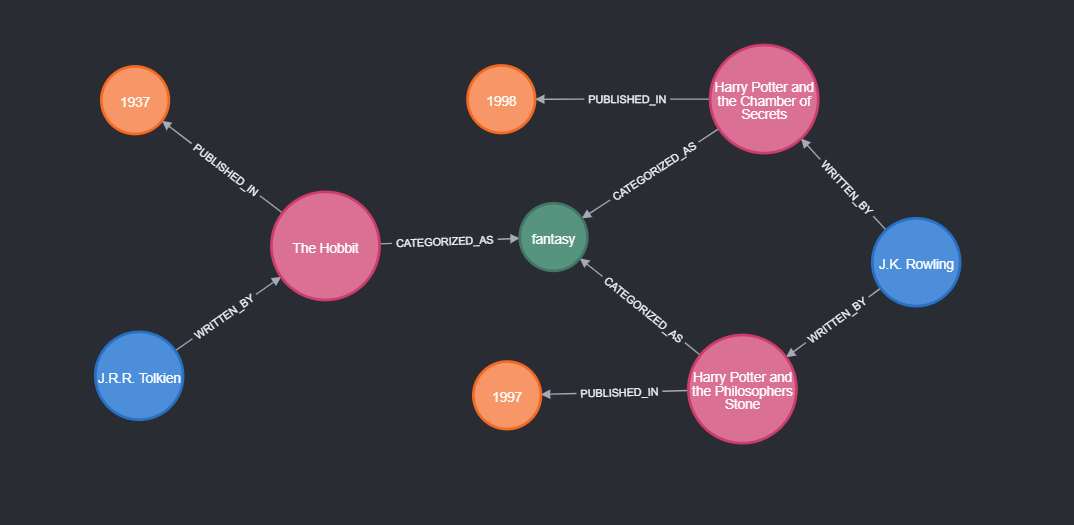